#### Basic work libraries 

In [1]:
import random
import pickle
import pandas as pd
import spotipy
from random import randint
from IPython.display import clear_output

from spotipy.oauth2 import SpotifyClientCredentials

#### Creating a spotipy object and conecting with key's file

In [2]:
secrets_file = open("spotkey.txt","r")
string = secrets_file.read()

secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

#### Loading the transfomer and cluster model previouly calculated

In [3]:
# Import previously saved models
def import_component(path):
    return pickle.load(open(path, 'rb'))

In [4]:
transformer = import_component('Model_data/scaler.sav')
model = import_component('Model_data/model_clustering.sav')

#### Loading our data to datasets

In [5]:
df_top100 = pd.read_csv('Data/Final/Top100.csv')
df_clustered = pd.read_csv('Data/Final/Spotify dataset clustered.csv')

In [6]:
# Function to obtain an uri from a song name
def song_uri(song_id):
    try:
        # Creating the spotipy element for the playlist URI
        querry = 'track:'+str(song_id)
        track = sp.search(q=song_id, limit=1)
        return track['tracks']['items'][0]['uri'].split('spotify:track:')[1]                 
    except:
        return 'Null'

In [7]:
# Function to get the song details of a specific URI
def get_details(uri):
    # Creatinga a dataframe with the columns that we need
    playlist_lst = ['danceability','energy','key','loudness','mode', 'speechiness',
                    'instrumentalness','liveness','valence','tempo',
                    'duration_ms','time_signature']
    
    playlist_df = pd.DataFrame(columns = playlist_lst)
    # Get audio features and adding them to the respective columns
    audio_features = sp.audio_features(uri)[0]
    playlist_df.loc[len(playlist_df)] = [audio_features[i] for i in playlist_lst]
    return playlist_df

#### Main working module

In [10]:
state = True
while state:
    
    # User inserts search term
    print('Insert song or search term:')
    search=input()
    if search == 'quit':
        state = False
    
    if state:
        # flag that controls if the search string exists in the songs dataset
        exist = False

        # testing if the search string exists
        for i in ['song', 'artist', 'genre']:
            if len(df_top100[df_top100[i].str.contains(search, case = False, regex = False)]) != 0:
                exist = True
        # if the song or search term exists in the dataset we sugest a random song, otherwise we search spotify
        if exist == True:
            clear_output()
            index = random.randint(0,len(df_top100))
            print('\nI have a sugestion! \n\nLink: ','https://open.spotify.com/track/'+df_top100['uri'].values[index],  '\nSong: ',df_top100['song'].values[index],  '\nArtist: ', df_top100['artist'].values[index])      
        else:
            # Using a try calause because the user can insert a song that's not on spotify, and the app will crash
            try:
                clear_output()
                # creating a single row dataframe with all the audio features from the song the user inserted
                df = get_details(song_uri(search))
                # calculating the cluster number for the song the user sugested
                cluster = model.predict(pd.DataFrame(transformer.transform(df), columns = df.columns))
                print('Spotify sugestion!')
                # filtering our dataset to a new dataset just containing the rows of the matching cluster of the user input song
                element = df_clustered[df_clustered['cluster'] == int(cluster)]
                # randomizing a row number from the subset
                index = random.randint(0,len(element))
                print('\nLink: ','https://open.spotify.com/track/'+element['track_id'].values[index],  '\nSong: ',element['track_name'].values[index],  '\nArtist: ', element['artist'].values[index])
            except:
                # Exception in the case that the song doesn't exists in spotify
                print('Invalid song. Sorry!')


Spotify sugestion!

Link:  https://open.spotify.com/track/6V2eaxScgdB3aF0aRw89gD 
Song:  Balou You're My New Best Friend 
Artist:  Lucas and Juliet
Insert song or search term:
quit


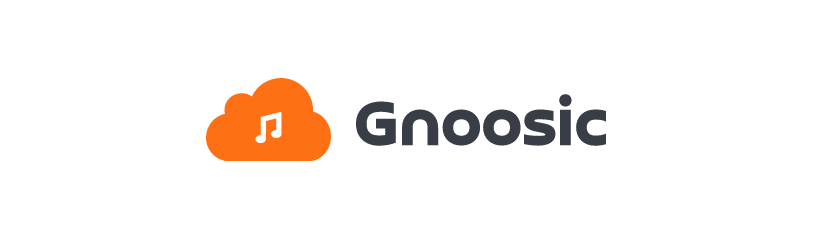